In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import scipy.stats as stats
import scipy.stats as stats
from draw_sky2 import draw_sky

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


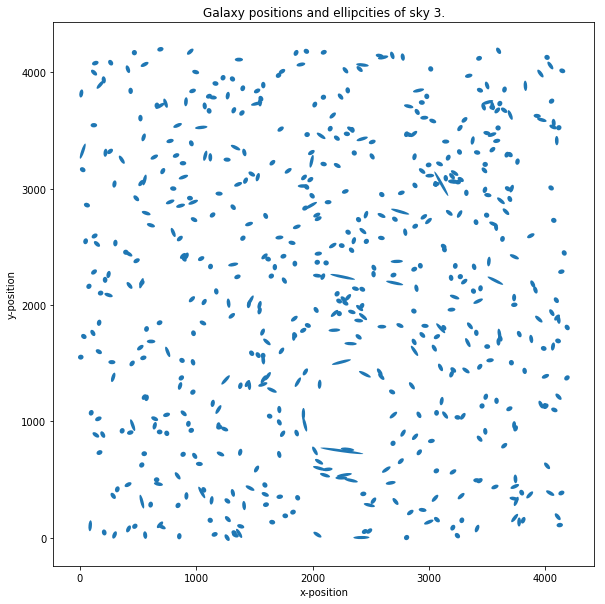

In [2]:
n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

### Priors

Each sky has one, two or three dark matter halos in it. Tim's solution details that his prior distribution of halo positions was uniform, i.e.

\begin{align}
& x_i \sim \text{Uniform}( 0, 4200)\\\\
& y_i \sim \text{Uniform}( 0, 4200), \;\; i=1,2,3\\\\
\end{align}

Tim and other competitors noted that most skies had one large halo and other halos, if present, were much smaller. Larger halos, having more mass, will influence the surrounding galaxies more. He decided that the large halos would have a mass distributed as a *log*-uniform random variable between 40 and 180 i.e.

$$  m_{\text{large} } = \log \text{Uniform}( 40, 180 ) $$

and in PyMC3, 

    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    mass_large = pm.Deterministic("mass_large", np.log(exp_max_large))

(This is what we mean when we say *log*-uniform.) For smaller galaxies, Tim set the mass to be the logarithm of 20. Why did Tim not create a prior for the smaller mass, nor treat it as a unknown? I believe this decision was made to speed up convergence of the algorithm. This is not too restrictive, as by construction the smaller halos have less influence on the galaxies.

Tim logically assumed that the ellipticity of each galaxy is dependent on the position of the halos, the distance between the galaxy and halo, and the mass of the halos. Thus the vector of ellipticity of each galaxy, $\mathbf{e}_i$, are *children* variables of the vector of halo positions $(\mathbf{x},\mathbf{y})$, distance (which we will formalize), and halo masses.

Tim conceived a relationship to connect positions and ellipticity by reading literature and forum posts. He supposed the following was a reasonable relationship:

$$ e_i | ( \mathbf{x}, \mathbf{y} ) \sim \text{Normal}( \sum_{j = \text{halo positions} }d_{i,j} m_j f( r_{i,j} ), \sigma^2 ) $$

where $d_{i,j}$ is the *tangential direction* (the direction in which halo $j$ bends the light of galaxy $i$), $m_j$ is the mass of halo $j$, $f(r_{i,j})$ is a *decreasing function* of the Euclidean distance between halo $j$ and galaxy $i$. 

Tim's function $f$ was defined:

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 240 ) } $$

for large halos, and for small halos

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 70 ) } $$

This fully bridges our observations and unknown. This model is incredibly simple, and Tim mentions this simplicity was purposefully designed: it prevents the model from overfitting.  


### Training & PyMC3 implementation

For each sky, we run our Bayesian model to find the posteriors for the halo positions &mdash; we ignore the (known) halo position. This is slightly different than perhaps traditional approaches to Kaggle competitions, where this model uses no data from other skies nor the known halo location. That does not mean other data are not necessary &mdash; in fact, the model was created by comparing different skies.

In [3]:
import pymc3 as pm
import theano.tensor as T

def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2)).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    # T.maximum() provides our element-wise maximum as in NumPy, but instead for theano tensors
    return T.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2*T.arctan(delta[:,1]/delta[:,0]))
    return T.stack([-T.cos(t), -T.sin(t)], axis=1)


with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large /\
            f_distance(T.as_tensor(data[:,:2]), halo_position, 240)*\
            tangential_distance(T.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [halo_position_interval__, mass_large_interval__]
 51%|█████     | 2796/5500 [00:06<00:06, 408.65it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '61895' (I am process '61896')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
 52%|█████▏    | 2848/5500 [00:06<00:06, 410.19it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '61895' (I am process '61897')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
100%|██████████| 5500/5500 [00:11<00:00, 460.38it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '61896' (I am process '61897')
INFO (theano.gof.compilelock): To manually release the lock, 

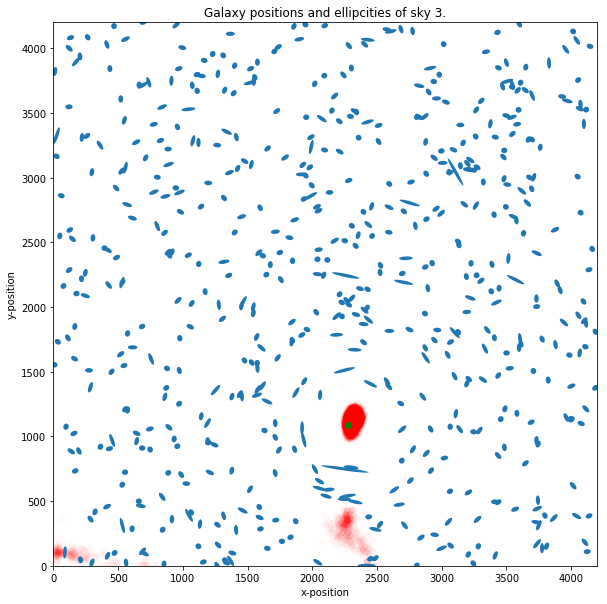

In [5]:
t = trace["halo_position"].reshape(20000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.scatter(t[:,0].mean(), t[:,1].mean(), alpha = 1, c = "g")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [6]:
halo_data = np.genfromtxt("data/Training_halos.csv", 
                          delimiter = ",",
                          usecols = [1, 2,3, 4,5,6,7,8,9],
                          skip_header = 1)
print(halo_data[n_sky])

[1.00000e+00 1.40861e+03 1.68586e+03 1.40861e+03 1.68586e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


True halo location: 1408.61 1685.86


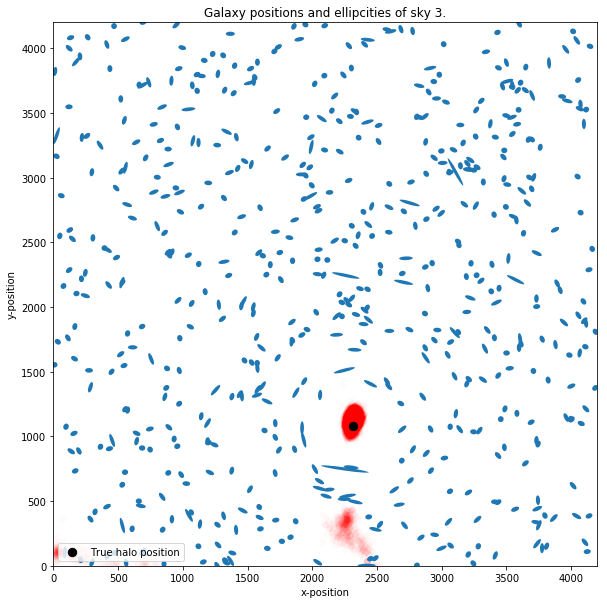

In [7]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], 
            label = "True halo position",
            c = "k", s = 70)
plt.legend(scatterpoints = 1, loc = "lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

In [8]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)

[[2277.62153263 1086.71715274]]


In [9]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky-1]

nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 38.45509560079619
Your average angular vector is 0.9999999999999999
Your score for the training data is 1.038455095600796
Using a random location: [[1821 3177]]
Your average distance in pixels you are away from the true halo is 2152.6824547294477
Your average angular vector is 1.0
Your score for the training data is 3.152682454729448


3.152682454729448

In [11]:
def halo_posteriors(n_halos_in_sky, galaxy_data,samples = 5e5, burn_in = 500):
    #set the size of the halo's mass
    with pm.Model() as model:
        mass_large = pm.Uniform("mass_large", 40, 180)
        
        mass_small_1 = 20
        mass_small_2 = 20
    
        masses = np.array([mass_large,mass_small_1, mass_small_2], dtype=object)
    
        #set the initial prior positions of the halos, it's a 2-d Uniform dist.
        halo_positions = pm.Uniform("halo_positions", 0, 4200, shape=(n_halos_in_sky,2)) #notice this size
    
        fdist_constants = np.array([240, 70, 70])
        
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += masses[i]/f_distance(data[:,:2], halo_positions[i, :], fdist_constants[i])*\
                tangential_distance(data[:,:2], halo_positions[i, :])
        
        mean = pm.Deterministic("mean", _sum)
               
        ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

        trace = pm.sample(samples)
        
    burned_trace = trace[burn_in:]
    return burned_trace["halo_positions"]

In [12]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])

In [13]:
#there are 3 halos in this file. 
samples = 5000
traces = halo_posteriors(3, data, samples = samples, burn_in=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [halo_positions_interval__, mass_large_interval__]
100%|██████████| 5500/5500 [19:52<00:00,  4.61it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7148693978542995, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5649820343692613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probabilit

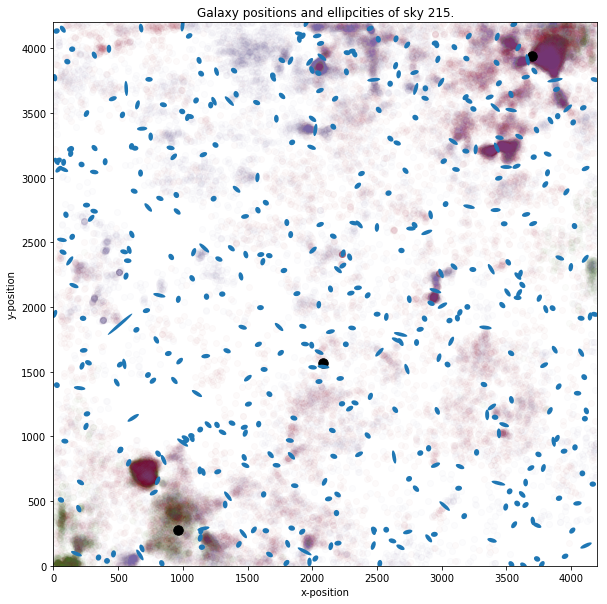

In [14]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0],  traces[:, i, 1], c = colors[i], alpha = 0.02)
    
    
for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
            label = "True halo position", c = "k", s = 90)
    
#plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

In [15]:
_halo_data = halo_data[n_sky-1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1,6)
print(mean_posterior)


nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior


print("Using the mean:")
main_score([1], x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

(18000, 3, 2)
[[2250.73367702 2226.95821743 2606.00876689 2605.71515497 2375.82873454
  2863.09588237]]
Using the mean:
Your average distance in pixels you are away from the true halo is 2243.109001292328
Your average angular vector is 1.0
Your score for the training data is 3.243109001292328
Using a random location: [[1295 1417]]
Your average distance in pixels you are away from the true halo is 3484.636361874794
Your average angular vector is 1.0
Your score for the training data is 4.484636361874794


4.484636361874794